In [1]:
import collections
import os
import json

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
import statsmodels.api as sm

if os.getcwd().endswith('notebook'):
    os.chdir('..')

from rna_learn.transform import (
    sequence_embedding, 
    normalize, denormalize,
    combine_sequences,
)
from rna_learn.model import (
    conv1d_densenet_regression_model, 
    dual_stream_conv1d_densenet_regression,
    compile_regression_model,
)

In [2]:
sns.set(palette='colorblind', font_scale=1.3)

In [3]:
ALPHABET_DNA = [
    'A', 'C', 'G', 'T',
]
ALPHABET_PROTEIN = [
    'A', 'C', 'D', 'E', 'F',
    'G', 'H', 'I', 'K', 'L',
    'M', 'N', 'P', 'Q', 'R', 
    'S', 'T', 'V', 'W', 'Y',
]

In [4]:
# run_id_dna = 'run_ca1ep'
run_id_dna = 'run_dzwlp'
run_id_protein = 'run_61iql'

dna_model_path = os.path.join(os.getcwd(), f'saved_models_gtdb/{run_id_dna}/model.h5')
dna_metadata_path = os.path.join(os.getcwd(), f'saved_models_gtdb/{run_id_dna}/metadata.json')

protein_model_path = os.path.join(os.getcwd(), f'saved_models_gtdb/{run_id_protein}/model.h5')
protein_metadata_path = os.path.join(os.getcwd(), f'saved_models_gtdb/{run_id_protein}/metadata.json')

train_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_train.csv')
test_set_path = os.path.join(os.getcwd(), 'data/gtdb/dataset_test.csv')

In [5]:
with open(dna_metadata_path) as f:
    dna_metadata = json.load(f)
    
dna_metadata

{'run_id': 'run_dzwlp',
 'alphabet': ['A', 'C', 'G', 'T'],
 'alphabet_type': 'dna',
 'growth_rate': 15,
 'n_layers': 5,
 'kernel_sizes': [2, 3, 5, 5, 10],
 'l2_reg': 0.0005,
 'dropout': 0.5,
 'n_epochs': 866,
 'seed': 7535,
 'val_loss': 1.2865286695687184,
 'val_mae': 15.531688690185547}

In [6]:
with open(protein_metadata_path) as f:
    protein_metadata = json.load(f)
    
protein_metadata

{'run_id': 'run_61iql',
 'alphabet': ['A',
  'C',
  'D',
  'E',
  'F',
  'G',
  'H',
  'I',
  'K',
  'L',
  'M',
  'N',
  'P',
  'Q',
  'R',
  'S',
  'T',
  'V',
  'W',
  'Y'],
 'alphabet_type': 'protein',
 'growth_rate': 15,
 'n_layers': 5,
 'kernel_sizes': [2, 3, 5, 5, 10],
 'strides': [1, 1, 1, 1, 1],
 'n_epochs': 282,
 'l2_reg': 0.0005,
 'dropout': 0.5,
 'seed': 108,
 'val_loss': 1.223247477962452,
 'val_mae': 14.174576759338379}

In [7]:
dual_model = True

if dual_model:
    dna_model = dual_stream_conv1d_densenet_regression(
        alphabet_size_1=len(ALPHABET_DNA), 
        alphabet_size_2=len(ALPHABET_PROTEIN), 
        growth_rate=dna_metadata['growth_rate'],
        n_layers=dna_metadata['n_layers'],
        kernel_sizes=dna_metadata['kernel_sizes'],
        l2_reg=dna_metadata['l2_reg'],
        dropout=dna_metadata['dropout'],
    )
else:
    dna_model = conv1d_densenet_regression_model(
        alphabet_size=len(ALPHABET_DNA) + len(ALPHABET_PROTEIN), 
        growth_rate=dna_metadata['growth_rate'],
        n_layers=dna_metadata['n_layers'],
        kernel_sizes=dna_metadata['kernel_sizes'],
        l2_reg=dna_metadata['l2_reg'],
        dropout=dna_metadata['dropout'],
    )
    
compile_regression_model(dna_model, learning_rate=1e-4)
dna_model.load_weights(dna_model_path)
dna_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 24)]   0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [(None, None, 4)]    0           sequence[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_1 (Te [(None, None, 20)]   0           sequence[0][0]                   
__________________________________________________________________________________________________
conv_0_1 (Conv1D)               (None, None, 15)     135         tf_op_layer_strided_slice[0][0]  
______________________________________________________________________________________________

In [8]:
protein_model = conv1d_densenet_regression_model(
    alphabet_size=len(ALPHABET_PROTEIN), 
    growth_rate=protein_metadata['growth_rate'],
    n_layers=protein_metadata['n_layers'],
    kernel_sizes=protein_metadata['kernel_sizes'],
    l2_reg=protein_metadata['l2_reg'],
    dropout=protein_metadata['dropout'],
)
compile_regression_model(protein_model, learning_rate=1e-4)
protein_model.load_weights(protein_model_path)
protein_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           [(None, None, 20)]   0                                            
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, None, 15)     615         sequence[0][0]                   
__________________________________________________________________________________________________
concat_1 (Concatenate)          (None, None, 35)     0           sequence[0][0]                   
                                                                 conv_1[0][0]                     
__________________________________________________________________________________________________
conv_2 (Conv1D)                 (None, None, 15)     1590        concat_1[0][0]             

In [9]:
train_df = pd.read_csv(train_set_path)
dataset_df = pd.read_csv(test_set_path)
dataset_df.head()

,accession,specie_name,domain,phylum,gtdb_genome_representative,temperature,temperature_range,gene_marker_id,gene_name,amino_acid_sequence,mrna_candidate_sequence
0,RS_GCF_003259265.1,Gelidibacter algens,Bacteria,Bacteroidota,RS_GCF_001678675.1,10.0,psychrophilic,PFAM_PF00380.14,Ribosomal_S9,ARAYVAKNIIPYSTYKPTNNGNFDVEALSREDANLLTVKKKF,GCTAGAGCTTACGTTGCAAAGAACATTATACCCTACTCAACGTATA...
1,RS_GCF_003259265.1,Gelidibacter algens,Bacteria,Bacteroidota,RS_GCF_001678675.1,10.0,psychrophilic,PFAM_PF00410.14,Ribosomal_S8,IYLTVVAHEIALETDQKSVKEPIKIKGASSEILAHTKHNVVY,ATCTACTTAACTGTCGTGGCCCACGAGATTGCGCTAGAGACCGACC...
2,RS_GCF_003259265.1,Gelidibacter algens,Bacteria,Bacteroidota,RS_GCF_001678675.1,10.0,psychrophilic,PFAM_PF00466.15,Ribosomal_L10,EVEELQTDISNNSELRFKAAVKTLLNKSDLSIMSEGNPKVIF,GAAGTCGAAGAGTTGCAAACTGACATTTCGAATAACTCAGAGCTCC...
3,RS_GCF_003259265.1,Gelidibacter algens,Bacteria,Bacteroidota,RS_GCF_001678675.1,10.0,psychrophilic,PFAM_PF01025.14,GrpE,NQL-EQLEDLDFKSLLLDESLEINFLEGTGNDLEAPSGIEYF,AATCAGCTA---GAGCAGTTAGAGGACCTAGATTTCAAGTCTCTCT...
4,RS_GCF_003259265.1,Gelidibacter algens,Bacteria,Bacteroidota,RS_GCF_001678675.1,10.0,psychrophilic,PFAM_PF02576.12,DUF150,---RDISVDGDVTSRAIEHDE-DSSRN--TDVGLDVLEKQLA,---------AGGGACATCTCCGTTGATGGGGACGTCACTAGCCGTG...


In [10]:
y_train = train_df['temperature'].values.astype('float64')
mean, std = np.mean(y_train), np.std(y_train)

In [11]:
dna_sequences = dataset_df['mrna_candidate_sequence'].values
protein_sequences = dataset_df['amino_acid_sequence'].values

x_protein = sequence_embedding(protein_sequences, ALPHABET_PROTEIN, dtype='float32')
x_dna = sequence_embedding(dna_sequences, ALPHABET_DNA, dtype='float32')
x_dna = combine_sequences(x_dna, x_protein, dtype='float32')

y = dataset_df['temperature'].values.astype('float32')
y_norm = normalize(y, mean, std)

## Models Evaluation

In [12]:
%%time
dna_model.evaluate(x_dna, y_norm, verbose=0)

CPU times: user 4.71 s, sys: 559 ms, total: 5.27 s
Wall time: 1.28 s


1.2968220071640058

In [13]:
%%time
protein_model.evaluate(x_protein, y_norm, verbose=0)

CPU times: user 1.28 s, sys: 167 ms, total: 1.45 s
Wall time: 557 ms


1.2533514274790742

In [14]:
y_hat_dna = dna_model(x_dna)
y_hat_protein = protein_model(x_protein)

In [15]:
y_mean_dna = denormalize(y_hat_dna.mean().numpy(), mean, std)
y_std_dna = denormalize(y_hat_dna.stddev().numpy(), mean, std)

y_mean_protein = denormalize(y_hat_protein.mean().numpy(), mean, std)
y_std_protein = denormalize(y_hat_protein.stddev().numpy(), mean, std)

In [16]:
np.mean(y_std_dna), np.mean(y_std_protein)

(52.187622, 50.6673)

In [17]:
mae_dna = np.mean(np.abs(y_mean_dna.flatten() - y))
rmse_dna = np.sqrt(np.mean((y_mean_dna.flatten() - y) **2))
correlation_dna = np.corrcoef(y, y_mean_dna.flatten())[0, 1]

print('DNA')
print(f'Mean Absolute Error    = {mae_dna:.2f}')
print(f'Root Mean Square Error = {rmse_dna:.2f}')
print(f'Correlation            = {correlation_dna:.2f}')

DNA
Mean Absolute Error    = 11.51
Root Mean Square Error = 14.32
Correlation            = 0.51


In [18]:
mae_protein = np.mean(np.abs(y_mean_protein.flatten() - y))
rmse_protein = np.sqrt(np.mean((y_mean_protein.flatten() - y) **2))
correlation_protein = np.corrcoef(y, y_mean_protein.flatten())[0, 1]

print('Protein')
print(f'Mean Absolute Error    = {mae_protein:.2f}')
print(f'Root Mean Square Error = {rmse_protein:.2f}')
print(f'Correlation            = {correlation_protein:.2f}')

Protein
Mean Absolute Error    = 10.76
Root Mean Square Error = 13.72
Correlation            = 0.57


In [19]:
def predictions_per_specie(dataset_df, y_true, y_pred):
    y_species_pred = []
    y_species_actual = []
    
    sequence_ids = sorted(dataset_df['gtdb_genome_representative'].unique().tolist())
    for sequence_id in sequence_ids:
        indices = dataset_df[dataset_df['gtdb_genome_representative'] == sequence_id].index
        
        truth = y_true[indices[0]]
        prediction = np.mean(y_pred[indices])
        
        y_species_actual.append(truth)
        y_species_pred.append(prediction)
    
    return np.array(y_species_actual), np.array(y_species_pred)

In [20]:
y_species_actual, y_species_pred_dna = predictions_per_specie(dataset_df, y, y_mean_dna)
_, y_species_pred_protein = predictions_per_specie(dataset_df, y, y_mean_protein)

In [21]:
def plot_true_vs_prediction_per_specie(y_true, y_pred):
    f, ax = plt.subplots(1, 1, figsize=(8, 8))
    
    palette = sns.color_palette()
    
    x_straight = range(0, 80)
    ax.plot(x_straight, x_straight, '--', color=palette[1], linewidth=2)
    
    for i in range(len(y_true)):
        y_t = y_true[i]
        y_p = y_pred[i]
        ax.plot(y_t, y_p, 'o', color=palette[0])
    
    ax.set_xlim(0, 80)
    ax.set_ylim(0, 80)
    ax.set_xlabel('Temperature °C (truth)')
    ax.set_ylabel('Temperature °C (prediction)')
    return f, ax

In [36]:
mae_species_dna = np.mean(np.abs(y_species_pred_dna.flatten() - y_species_actual))
rmse_species_dna = np.sqrt(np.mean((y_species_pred_dna.flatten() - y_species_actual) **2))
corr_species_dna = np.corrcoef(y_species_actual, y_species_pred_dna.flatten())[0, 1]

mae_species_protein = np.mean(np.abs(y_species_pred_protein.flatten() - y_species_actual))
rmse_species_protein = np.sqrt(np.mean((y_species_pred_protein.flatten() - y_species_actual) **2))
corr_species_protein = np.corrcoef(y_species_actual, y_species_pred_protein.flatten())[0, 1]

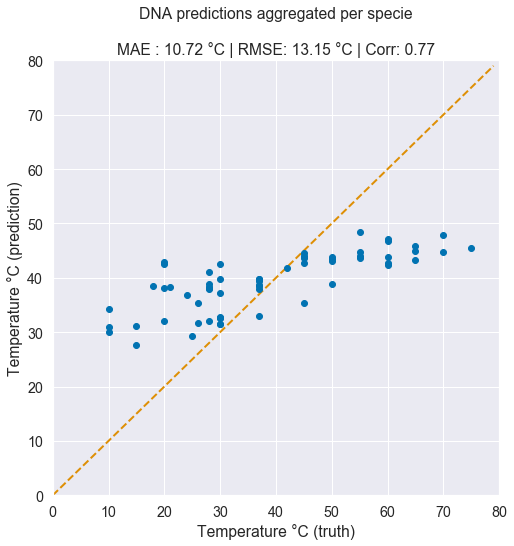

In [37]:
f, ax = plot_true_vs_prediction_per_specie(y_species_actual, y_species_pred_dna);
title = f'DNA predictions aggregated per specie\n\n'
title += f'MAE : {mae_species_dna:.2f} °C | '
title += f'RMSE: {rmse_species_dna:.2f} °C | '
title += f'Corr: {corr_species_dna:.2f}'
ax.set_title(title);

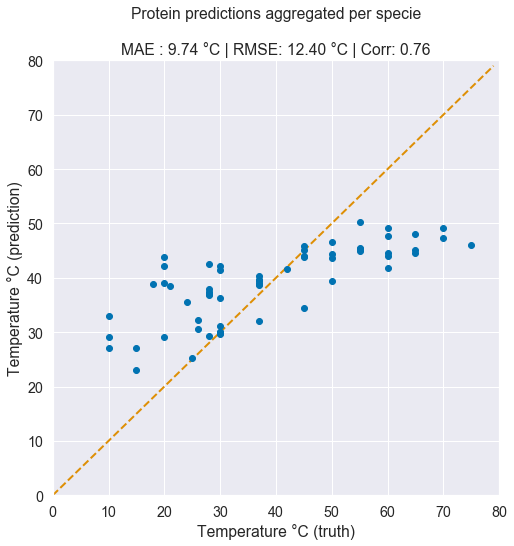

In [38]:
f, ax = plot_true_vs_prediction_per_specie(y_species_actual, y_species_pred_protein);
title = f'Protein predictions aggregated per specie\n\n'
title += f'MAE : {mae_species_protein:.2f} °C | '
title += f'RMSE: {rmse_species_protein:.2f} °C | '
title += f'Corr: {corr_species_protein:.2f}'
ax.set_title(title);

In [25]:
def get_IVYWREL_content_per_specie(dataset_df):
    IVYWREL_content = []
    
    letters = {'I', 'V', 'Y', 'W', 'R', 'E', 'L'}
    
    sequence_ids = sorted(dataset_df['gtdb_genome_representative'].unique().tolist())
    for sequence_id in sequence_ids:
        sequences = dataset_df[dataset_df['gtdb_genome_representative'] == sequence_id]['amino_acid_sequence'].values
        
        sequence_str = ''
        for sequence in sequences:
            sequence_str += str(sequence)
        
        length = len(sequence_str)
        n = len([b for b in sequence_str if b in letters])
        IVYWREL_content.append(n / length)
    
    return np.array(IVYWREL_content)

In [26]:
IVYWREL_content = get_IVYWREL_content_per_specie(dataset_df)

In [27]:
def fit_line(y_species_actual, IVYWREL_content):
    f, ax = plt.subplots(1, 1, figsize=(12, 6))
    
    palette = sns.color_palette()
    
    X_bins = sm.add_constant(IVYWREL_content[:,np.newaxis])
    model = sm.OLS(y_species_actual, X_bins)

    results = model.fit()

    p_value = results.f_pvalue

    a = results.params[1]
    b = results.params[0]
    y_fit = a * IVYWREL_content + b
    
    ax.plot(IVYWREL_content, y_species_actual, 'o', color=palette[0], label='actual')
    ax.plot(IVYWREL_content, y_fit, color=palette[1], linewidth=1, label=f'p = {p_value:.1e}')
    
    ax.set_xlabel('IVYWREL content')
    ax.set_ylabel('Optimal Growth Temperature °C')
    ax.legend()
    
    ax.set_title('IVYWREL vs OGT')
    
    return a, b, y_fit, p_value

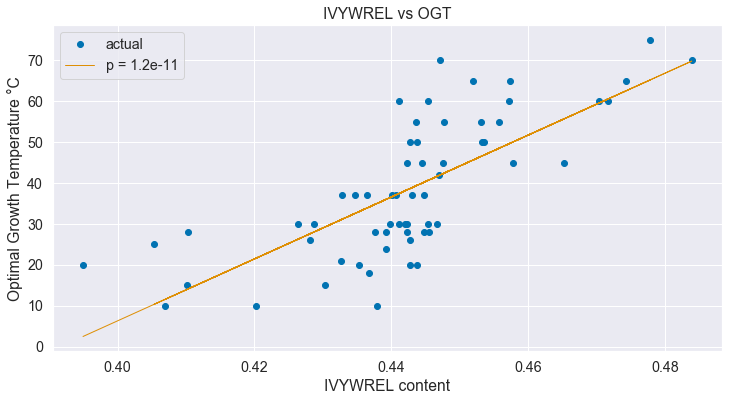

In [28]:
a, b, y_fit, p_value = fit_line(y_species_actual, IVYWREL_content)

In [29]:
mae_IVYWREL = np.mean(np.abs(y_fit - y_species_actual))
rmse_IVYWREL = np.sqrt(np.mean((y_fit - y_species_actual) **2))
corr_IVYWREL = np.corrcoef(y_species_actual, y_fit)[0, 1]

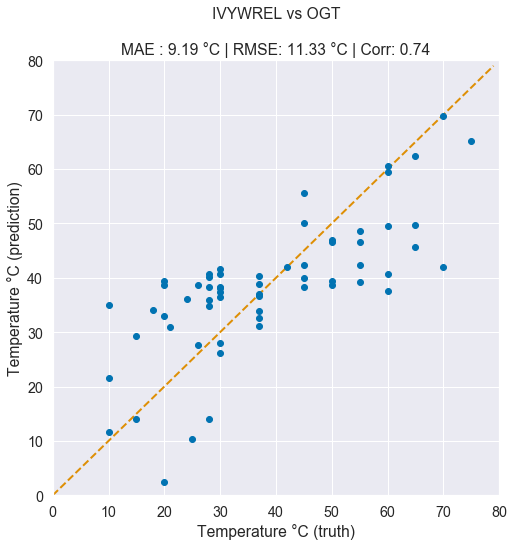

In [30]:
f, ax = plot_true_vs_prediction_per_specie(y_species_actual, y_fit);
title = f'IVYWREL vs OGT\n\n'
title += f'MAE : {mae_IVYWREL:.2f} °C | '
title += f'RMSE: {rmse_IVYWREL:.2f} °C | '
title += f'Corr: {corr_IVYWREL:.2f}'
ax.set_title(title);

In [32]:
predictions_mean = np.array([np.mean(y_species_actual)] * len(y_species_actual))

mae_species_mean = np.mean(np.abs(predictions_mean - y_species_actual))
rmse_species_mean = np.sqrt(np.mean((predictions_mean - y_species_actual) **2))
corr_species_mean = np.corrcoef(y_species_actual, predictions_mean)[0, 1]

print('Mean baseline')
print(f'MAE  = {mae_species_mean:.2f}')
print(f'RMSE = {rmse_species_mean:.2f}')

Mean baseline
MAE  = 14.31
RMSE = 16.78
